# Importing necessary Libraries

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import os
import PIL
import random

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from keras.optimizers import Adam


import warnings
warnings.filterwarnings("ignore")

# Load the Flower Dataset

In [ ]:
 # Load the dataset with labels
dataset_name = "tf_flowers"
(train_data, val_data, test_data), dataset_info = tfds.load(
    dataset_name,
    split=["train[:70%]", "train[70%:85%]", "train[85%:]"],
    as_supervised=True,
    with_info=True
)

# Number of classes
num_classes = dataset_info.features["label"].num_classes
print(f"Number of classes: {num_classes}")

Number of classes: 5


# Preprocess the Dataset

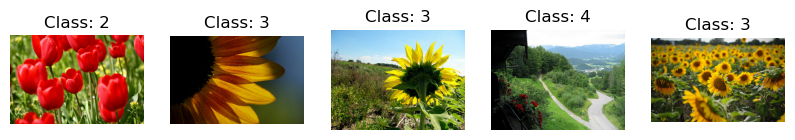

In [ ]:
# Load dataset without batching to fetch individual images
raw_train_data, _ = tfds.load("tf_flowers", split="train", as_supervised=True, with_info=True)

# Function to display images
def show_sample_images(dataset, num_images=5):
    plt.figure(figsize=(10, 5))
    for i, (image, label) in enumerate(dataset.take(num_images)):
        plt.subplot(1, num_images, i+1)
        plt.imshow(image.numpy().astype("uint8"))
        plt.axis("off")
        plt.title(f"Class: {label.numpy()}")
    plt.show()

# Display images
show_sample_images(raw_train_data)


In [ ]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Data Preprocessing Function
def preprocess(image, label):
    image = tf.image.resize(image, IMG_SIZE)  # Resize Images
    image = image / 255.0  # Normalize pixel values [0,1]
    return image, tf.one_hot(label, depth=num_classes) # Encoding the labelled data

# Apply preprocessing & batch data
train_data = (train_data
              .map(preprocess) # Applies the preprocess function to every image-label pair
              .batch(BATCH_SIZE) # Groups images into mini-batches of 32 images
              .shuffle(1000)  # Randomly shuffles the dataset with a buffer size of 1000 images
              .prefetch(tf.data.experimental.AUTOTUNE))   # Optimizes data loading by preloading the next batch while training is running

val_data = (val_data
            .map(preprocess)
            .batch(BATCH_SIZE)
            .prefetch(tf.data.experimental.AUTOTUNE))

test_data = (test_data
             .map(preprocess)
             .batch(BATCH_SIZE)
             .prefetch(tf.data.experimental.AUTOTUNE))

# Load Pretrained Model (MobileNetV2)

In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model

# Load pretrained MobileNetV2 model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze base layers

# Add new classification layers
x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
output = Dense(num_classes, activation='softmax')(x)

# Create model
model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,422,597 (9.24 MB)

 Trainable params: 164,613 (643.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

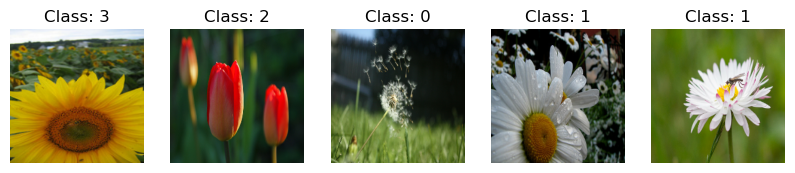

In [ ]:
# Fetch some processed images
sample_images, sample_labels = next(iter(train_data))

# Convert tensor to numpy for visualization
sample_images = sample_images.numpy()
sample_labels = tf.argmax(sample_labels, axis=1).numpy()

# Plot preprocessed images
plt.figure(figsize=(10, 5))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(sample_images[i])
    plt.axis("off")
    plt.title(f"Class: {sample_labels[i]}")
plt.show()

# Train the Model

In [ ]:
# Train top layers
history = model.fit(train_data, validation_data=val_data, epochs=10)

# Fine-tune: Unfreeze last 30 layers
base_model.trainable = True
for layer in base_model.layers[:-30]:  # Freeze all but last 30 layers
    layer.trainable = False

# Recompile with lower learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Continue training
history_fine = model.fit(train_data, validation_data=val_data, epochs=10)


Epoch 1/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 127s 1s/step - accuracy: 0.6043 - loss: 1.0643 - val_accuracy: 0.8494 - val_loss: 0.4464
Epoch 2/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 113s 1s/step - accuracy: 0.8365 - loss: 0.4656 - val_accuracy: 0.8566 - val_loss: 0.4129
Epoch 3/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 92s 1s/step - accuracy: 0.8467 - loss: 0.4111 - val_accuracy: 0.8512 - val_loss: 0.4010
Epoch 4/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 88s 1s/step - accuracy: 0.8613 - loss: 0.3525 - val_accuracy: 0.8748 - val_loss: 0.3756
Epoch 5/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - accuracy: 0.8934 - loss: 0.3157 - val_accuracy: 0.8784 - val_loss: 0.3517
Epoch 6/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 81s 978ms/step - accuracy: 0.8903 - loss: 0.2701 - val_accuracy: 0.9002 - val_loss: 0.3289
Epoch 7/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 81s 991ms/step - accuracy: 0.9118 - loss: 0.2547 - val_accuracy: 0.8984 - val_loss: 0.3151
Epoch 8/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 78s 953ms/step - accuracy: 0.9078 - loss: 0.2391 - val_accuracy: 0.8966 

# Evaluate Model Performance

18/18 ━━━━━━━━━━━━━━━━━━━━ 15s 813ms/step - accuracy: 0.9105 - loss: 0.3672
Test Accuracy: 0.93
18/18 ━━━━━━━━━━━━━━━━━━━━ 20s 929ms/step


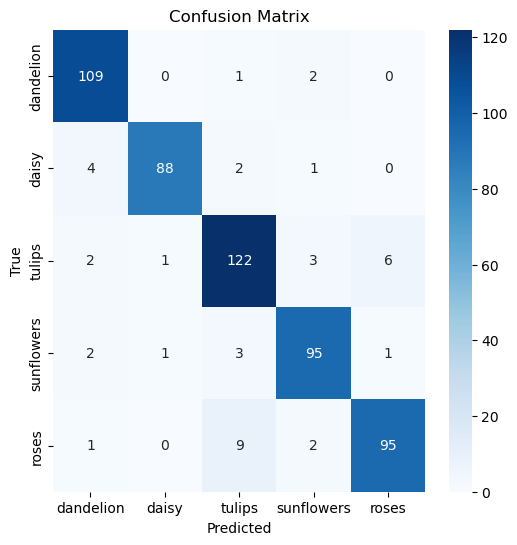

              precision    recall  f1-score   support

   dandelion       0.92      0.97      0.95       112
       daisy       0.98      0.93      0.95        95
      tulips       0.89      0.91      0.90       134
  sunflowers       0.92      0.93      0.93       102
       roses       0.93      0.89      0.91       107

    accuracy                           0.93       550
   macro avg       0.93      0.93      0.93       550
weighted avg       0.93      0.93      0.93       550



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Test the model
test_loss, test_acc = model.evaluate(test_data)
print(f"Test Accuracy: {test_acc:.2f}")

# Get predictions and true labels
predictions = np.argmax(model.predict(test_data), axis=-1)
true_labels = np.concatenate([y.numpy().argmax(axis=-1) for _, y in test_data], axis=0)

# Generate confusion matrix
conf_matrix = confusion_matrix(true_labels, predictions)

# Plot confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=dataset_info.features["label"].names,
            yticklabels=dataset_info.features["label"].names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print(classification_report(true_labels, predictions, target_names=dataset_info.features["label"].names))

# Checking Images

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


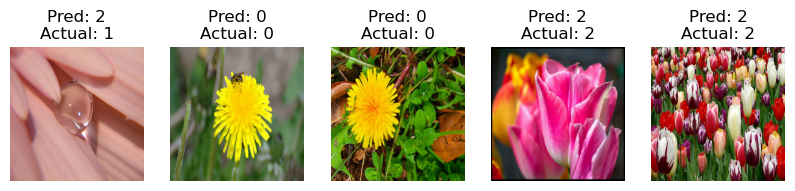

In [ ]:
# Fetch some test images
sample_test_images, sample_test_labels = next(iter(test_data))
predictions = model.predict(sample_test_images)
predicted_labels = np.argmax(predictions, axis=-1)

# Plot predictions
plt.figure(figsize=(10, 5))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(sample_test_images[i].numpy())
    plt.axis("off")
    plt.title(f"Pred: {predicted_labels[i]}\nActual: {tf.argmax(sample_test_labels[i]).numpy()}")
plt.show()


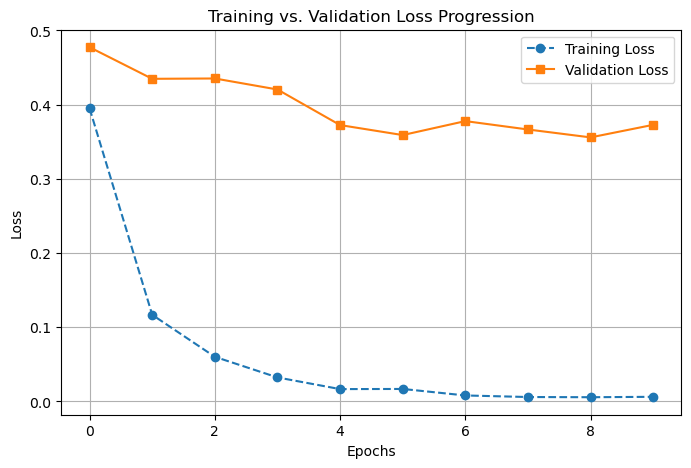

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(history_fine.history['loss'], label="Training Loss", marker='o', linestyle='--')
plt.plot(history_fine.history['val_loss'], label="Validation Loss", marker='s', linestyle='-')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs. Validation Loss Progression")
plt.legend()
plt.grid(True)
plt.show()

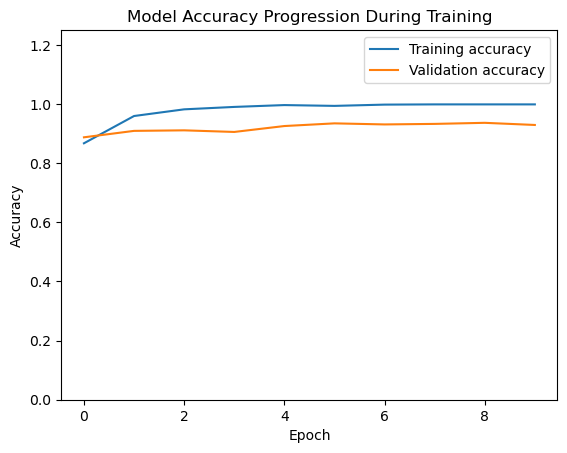

In [ ]:
plt.title("Model Accuracy Progression During Training")
plt.plot(history_fine.history['accuracy'])
plt.plot(history_fine.history['val_accuracy'])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim(0, 1.25)
plt.legend(["Training accuracy", "Validation accuracy"])
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


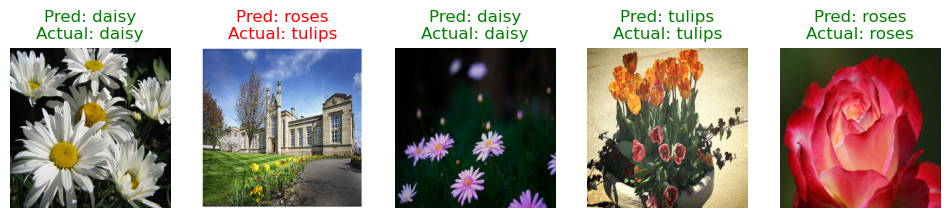

In [ ]:
# Get class names from the dataset
class_names = dataset_info.features["label"].names

# Function to display random test images with predictions
def show_random_predictions(model, test_data, num_images=5):
    # Get a batch of test images and labels
    sample_images, sample_labels = next(iter(test_data))

    # Convert tensors to numpy arrays
    sample_images = sample_images.numpy()
    sample_labels = tf.argmax(sample_labels, axis=1).numpy()

    # Select random indices
    random_indices = random.sample(range(len(sample_images)), num_images)

    plt.figure(figsize=(12, 5))
    for i, idx in enumerate(random_indices):
        img = sample_images[idx]
        true_label = sample_labels[idx]

        # Get model prediction
        pred_probs = model.predict(np.expand_dims(img, axis=0))
        pred_label = np.argmax(pred_probs)

        # Plot image
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"Pred: {class_names[pred_label]}\nActual: {class_names[true_label]}",
                  color="green" if pred_label == true_label else "red")

    plt.show()

# Call function to visualize random predictions
show_random_predictions(model, test_data, num_images=5)


# Conclusion:

I used MobileNetV2 with its convolutional base frozen and added a custom classification head consisting of a Global Average Pooling (GAP) layer, a fully connected dense layer with 128 neurons (ReLU activation), and a final softmax layer for classification. After initial training, I unfroze the last few layers of MobileNetV2 and fine-tuned them to improve accuracy.

Initially, I trained only the top layers for 10 epochs using Adam optimizer and categorical cross-entropy loss. Then, unfrozed the last 20 layers of MobileNetV2 and fine-tuned the model for another 10 epochs with a lower learning rate (1e-5) to avoid overfitting.

The final model achieved 93.0% accuracy on the test set, which met the expectations. However, some flower types with similar colors were misclassified. With more data and hyperparameter tuning, further improvements are possible. This model could be useful for automatic plant identification in agricultural applications.